# Week 6 - Vector Space Word Embeddings
Student Name: Tianyue Niu

This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them. Documents here are represented as densely indexed locations in dimensions, rather than sparse mixtures of topics (as in LDA topic modeling), so that distances between those documents (and words) are consistently superior, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

For this notebook we will be using the following packages

In [362]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas as pd#Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

#Ohter packages
import re
import time
import copy

# uncomment to install pubmed_parser on rcc
# !pip install --user git+http://github.com/titipata/pubmed_parser.git
import pubmed_parser as pp

### Data Cleaning

    In the final project, our team intend to use compare trendy psychology-related research topics across time. So for an initial exploration, in this assignment, I will be using data from 1985 and 2019. I will then compare them to see if there are any interesting differences, using the techniques covered.
    
    First, I download corresponding (2019 & 1985) pubmed baseline xml files from pubmed. I then parse the xml files, filter out psychology-related article based on abstract keywords as I did in the previous assignment, and store the data into a pandas dataframe.

In [38]:
def process_data(filename):
    
    # filtering criteria: psyc-related abstract
    psych_keywords = ['psych', 'behavior', 'neur']

    def isPsych(abstract, keywords):
        return any(word in abstract for word in keywords)
    
    def process_one_pubmed_gzip(file_name):
        start = time.time()
        # parse xml to df
        pubmed_parsed = pp.parse_medline_xml("./" + file_name)
        pubmed_df = pd.DataFrame(pubmed_parsed)

        pubmed_norm = pd.DataFrame(index=pubmed_df.index, columns=['flag_psych'], dtype=object)
        for row in pubmed_df.itertuples():
            #flag pschology articles
            pubmed_norm.at[row.Index, 'flag_psych'] = isPsych(row.abstract + row.title, psych_keywords)

        combined_df = pd.concat([pubmed_df, pubmed_norm], axis = 1)

        elapsed = time.time() - start
        print("File " + file_name + " done (" + '%.3f' % elapsed + ' s)')

        return combined_df

    # processing each file takes ~ 2 min on my own laptop
    df = process_one_pubmed_gzip(filename)

    data = df[df.abstract!=''][['title','abstract','affiliations','authors',
                                'chemical_list','country','pubdate','flag_psych']]
    
    #filter out psychology abstracts from all abstracts
    psyc = data[data['flag_psych']].reset_index(drop=True)
    
    return psyc

In [39]:
psyc_old = process_data('./pubmed20n0135.xml.gz') 
psyc_new = process_data('./pubmed20n1014.xml.gz') 

File ./pubmed20n0135.xml.gz done (12.743 s)
File ./pubmed20n1014.xml.gz done (13.850 s)


In [40]:
#we will concat these two data and keep only 2019 and 1985
psyc = pd.concat([psyc_old, psyc_new[psyc_new['pubdate']=='2019']], axis=0)
psyc.head(5)

,title,abstract,affiliations,authors,chemical_list,country,pubdate,flag_psych
0,Clinical restoration of voice function after l...,One hundred eleven patients with unilateral vo...,,RS Weber;L Neumayer;BR Alford;SC Weber,D011138:Polytetrafluoroethylene,United States,1985,True
1,Ultrastructural immunocytochemical localizatio...,"Using pre- and post-embedding procedures, neur...",,M Zabel;H Schäfer,D002116:Calcitonin; D010751:Phosphopyruvate Hy...,Germany,1985,True
2,Demonstration of reduced levels of zinc in rat...,Histochemical and atomic absorption spectropho...,,P Szerdahelyi;P Kása,D008345:Manganese; D003300:Copper; D012110:Res...,Germany,1985,True
3,Radical irradiation and misonidazole in the tr...,"Between February 1979 and January 1982, a Phas...",,T Girinski;MH Pejovic;C Haie;M Bonnay;A Gerbau...,D008920:Misonidazole,United States,1985,True
4,Psychoanalytic observations on vulnerability t...,The psychological indicators discussed in this...,,S Silverman,,United States,1985,True


In [41]:
psyc.pubdate.value_counts()

2019    4331
1985    2500
Name: pubdate, dtype: int64

In [42]:
#normalize and tokenize （took really long to run)
psyc['tokenized_abstract'] = psyc['abstract'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
psyc['normalized_abstract'] = psyc['tokenized_abstract'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])

## <span style="color:purple">*Exercise 1*</span>

<span style="color:purple">Construct cells immediately below this that embed documents related to your final project using at least two different specification of `word2vec`, and visualize them each with two separate visualization layout specifications (e.g., TSNE, PCA). Then interrogate critical word vectors within your corpus in terms of the most similar words, analogies, and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the semantic organization of words in your corpora? Which estimation and visualization specification generate the most insight and appear the most robustly supported and why? 

<span style="color:purple">***Stretch***: Explore different vector calculations beyond addition and subtraction, such as multiplication, division or some other function. What does this exploration reveal about the semantic structure of your corpus?

In [48]:
#split psyc into two different dfs (2019 and 1985)
psyc_2019 = psyc[psyc['pubdate']=='2019']
psyc_1985 = psyc[psyc['pubdate']=='1985']

In [74]:
abstractW2V_2019 = gensim.models.word2vec.Word2Vec(psyc_2019['normalized_abstract'].sum())
abstractW2V_1985 = gensim.models.word2vec.Word2Vec(psyc_1985['normalized_abstract'].sum())

In [79]:
#let's examine most similar words to a few words in 1985 and 2019
def show_similar_word(word):
    print('1985 similar words to {}: \n'.format(word))
    print(abstractW2V_1985.most_similar(word))
    print('\n')
    print('2019 similar words to {}:\n'.format(word))
    print(abstractW2V_2019.most_similar(word))
    return

In [80]:
show_similar_word('alzheimer')

1985 similar words to alzheimer: 

[('signs', 0.9995848536491394), ('syndrome', 0.999527096748352), ('depressive', 0.9995089173316956), ('pain', 0.9994950294494629), ('history', 0.9994756579399109), ('diagnostic', 0.9994703531265259), ('presented', 0.9994685053825378), ('personality', 0.9994525909423828), ('aneurysms', 0.9994511008262634), ('disorder', 0.9994498491287231)]


2019 similar words to alzheimer:

[('parkinson', 0.9888819456100464), ('huntington', 0.9877595901489258), ('progression', 0.9856910705566406), ('sclerosis', 0.9772396683692932), ('cln2', 0.9696634411811829), ('lyme', 0.9671977162361145), ('vad', 0.9657162427902222), ('csvd', 0.9631310701370239), ('als', 0.9626093506813049), ('amyotrophic', 0.9620776176452637)]


    We see in the 2019 corpurs, similar words to Alzheimer include a list of brain disorders like 'Parkinson', 'Huntington' etc. In the 1985 corpus, however, the closest we see to brain disorders are 'aneurysm' and 'disorder', which do not specific brain-related diseases. This probably shows that compared with 1985, researchers are more concerned with neuro-degenerative diseases like Alzheimer in 2019.

In [64]:
show_similar_word('study')

1985 similar words to study 

[('findings', 0.9976831078529358), ('present', 0.9976017475128174), ('clinical', 0.9972925782203674), ('studies', 0.9972891807556152), ('discussed', 0.9971560835838318), ('previous', 0.9965497255325317), ('implications', 0.9964312314987183), ('data', 0.9960595369338989), ('confirm', 0.995940625667572), ('authors', 0.9955426454544067)]


2019 similar words to 

[('studies', 0.8092811703681946), ('evaluate', 0.7683776617050171), ('cross', 0.7665051221847534), ('assess', 0.7620676755905151), ('case', 0.7587990164756775), ('aim', 0.7557386159896851), ('review', 0.7557028532028198), ('sectional', 0.745079517364502), ('objective', 0.7447528839111328), ('determine', 0.7441883087158203)]


    The above are words similar to 'study' in the 1985 and 2019 corpora. We see that in 1985, 'study' is most similar to words such as 'findings', 'authors', 'data', which are mainly nouns, whereas in 2019, 'study' is most similar to 'evaluate', 'aim', 'assess', 'determine', which are mainly verbs. 

In [83]:
#now let's examine the structure of these corpora closer
abstractW2V_2019.doesnt_match(['neuron', 'axon', 
                               'dendrite', 'study'])

'study'

In [84]:
abstractW2V_1985.doesnt_match(['neuron', 'axon', 
                               'dendrite', 'study'])

'study'

    Neuron, axon and dendrite should be very similar words, and we do see that in both 1985 and 2019's corpus, 'study' was identified as the word that least matches with the other three words.

In [109]:
#Now let's visualize these words
#manually select a list of words
targetWords = ['memory', 'hippocampus', 'aging','anxiety','sleep','disorder','autism',
               'dementia','alzheimer','parkinson', 'cognition','brain', 'control', 'study',
               'attention', 'neuron','axon','synaptic','plasticity','hypothalamus']
len(targetWords)

20

In [110]:
wordsSubMatrix_1985 = []
wordsSubMatrix_2019 = []

for word in targetWords:
    wordsSubMatrix_1985.append(abstractW2V_1985[word])
    wordsSubMatrix_2019.append(abstractW2V_2019[word])

wordsSubMatrix_2019 = np.array(wordsSubMatrix_2019)
wordsSubMatrix_1985 = np.array(wordsSubMatrix_1985)

In [129]:
def visualize_word_matrix(targetWords, wordsSubMatrix, numWords):
    pcaWords = sklearn.decomposition.PCA(n_components = 15).fit(wordsSubMatrix)
    reducedPCA_data = pcaWords.transform(wordsSubMatrix)
    #T-SNE is theoretically better, but you should experiment
    tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)
    
    fig = plt.figure(figsize = (18,8))
    plt.subplot(1,2,1)
    plt.title('TNSE')
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
    for i, word in enumerate(targetWords):
        ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]))
    
    plt.subplot(1,2,2)
    plt.title('PCA')
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], alpha = 0)#Making the points invisible 
    for i, word in enumerate(targetWords):
        ax.annotate(word, (reducedPCA_data[:, 0][i],reducedPCA_data[:, 1][i]))
        
    return

Based on 1985 Corpus


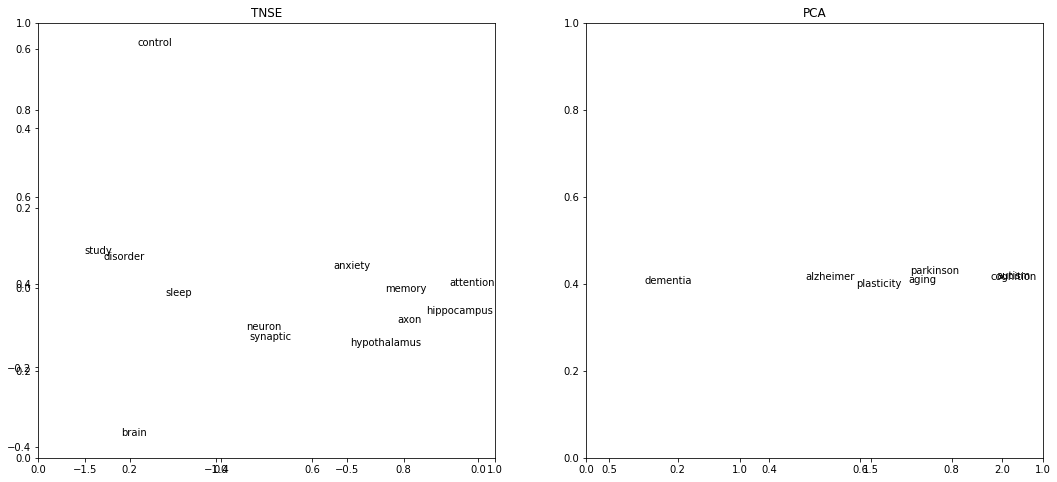

In [133]:
print('Based on 1985 Corpus')
visualize_word_matrix(targetWords, wordsSubMatrix_1985, 20)

Based on 2019 Corpus


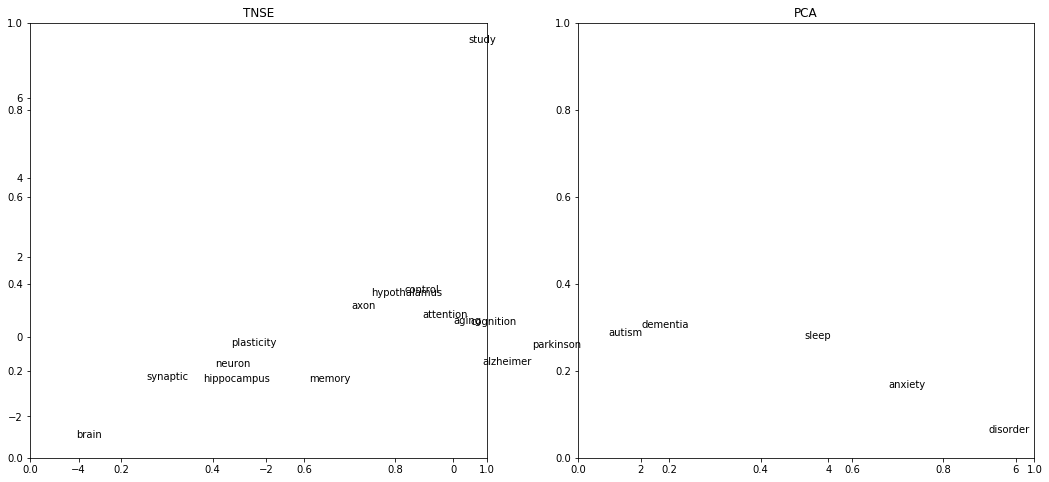

In [132]:
print('Based on 2019 Corpus')
visualize_word_matrix(targetWords, wordsSubMatrix_2019, 20)

        Just by visual inspection, we see that TSNE seemed to be more accurate for both 2019 and 1985 corpus. Reduced PCA plot contained less key words, and its results seem a little inaccurate (e.g. the distance between dementia and alzheimer is farther than the distance between parkinson and cognition in 1985 plot, which seems intuitively wrong; also in 2019 plot, dementia is very close to autism, which doesn't make much sense because dementia is not a characterizing symptom for autism).

## <span style="color:purple">*Exercise 2*</span>

<span style="color:purple">Construct cells immediately below this that embed documents related to your final project using `doc2vec`, and explore the relationship between different documents and the word vectors you analyzed in the last exercise. Consider the most similar words to critical documents, analogies (doc _x_ + word _y_), and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the documentary organization of your semantic space?

In [151]:
#For this exercise we'll just use the entire dataset (1985 + 2019)
psyc = psyc.reset_index(drop=True)

In [162]:
psyc['tokenized_abstract_words'] = psyc['abstract'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
psyc['normalized_words'] = psyc['tokenized_abstract_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [168]:
#Manually list keywords associated with alzheimer, without actually include the word 'alzheimer'
keywords = ['tau', 'beta', 'amyloid', 'dementia', 'hippocampus', 'aging', 'plaque', 'memory']

taggedDocs = []
for index, row in psyc.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['title'])
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
    
psyc['TaggedAbstracts'] = taggedDocs

In [196]:
psyc['TaggedAbstracts'][1774]

LabeledSentence(words=['protein', 'component', 'alzheimer', 'disease', 'amyloid', 'neurofibrillary', 'tangles', 'nft', 'amyloid', 'plaque', 'core', 'congophilic', 'angiopathy', 'aggregated', 'polypeptide', 'subunit', 'mass', 'kd', 'a4', 'monomer', 'based', 'degree', 'n', 'terminal', 'heterogeneity', 'amyloid', 'deposited', 'neuron', 'later', 'extracellular', 'space', 'antisera', 'raised', 'synthetic', 'peptides', 'n', 'terminus', 'a4', 'residues', 'contains', 'epitope', 'neurofibrillary', 'tangles', 'inner', 'region', 'molecule', 'residues', 'contains', 'epitope', 'plaque', 'cores', 'vascular', 'amyloid', 'non', 'protein', 'component', 'amyloid', 'aluminum', 'silicate', 'form', 'basis', 'deposition', 'amplification', 'possible', 'self', 'replication', 'aggregated', 'amyloid', 'protein', 'amyloid', 'alzheimer', 'disease', 'similar', 'subunit', 'size', 'composition', 'sequence', 'scrapie', 'associated', 'fibril', 'constituent', 'polypeptides', 'sequence', 'composition', 'nft', 'homologou

In [212]:
psyc['TaggedAbstracts'][120]

LabeledSentence(words=['impetus', 'widespread', 'use', 'cbt', 'children', 'attention', 'deficit', 'disorder', 'hyperactivity', 'examined', 'followed', 'evaluation', 'facets', 'treatment', 'efficacy', 'unknowns', 'concerning', 'treatment', 'ingredients', 'targets', 'change', 'domain', 'specificity', 'individual', 'differences', 'palatability', 'treatment', 'emergent', 'effects', 'reviewed', 'final', 'section', 'focuses', 'future', 'directions', 'specifying', 'reasons', 'optimism', 'despite', 'disappointing', 'outcomes', 'date', 'nontraditional', 'uses', 'cbt', 'proposed', 'including', 'implementation', 'cognitive', 'strategies', 'counteract', 'undesirable', 'emanative', 'effects', 'extant', 'treatments', 'facilitate', 'drug', 'discontinuance', 'children', 'taking', 'psychoactive', 'medication'], tags=['Cognitive-behavioral therapies for hyperactive children: premises, problems, and prospects.'])

In [170]:
keywordsD2V = gensim.models.doc2vec.Doc2Vec(psyc['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

In [182]:
keywordsD2V.most_similar(positive = ['memory','hippocampus'], negative = ['hypothalamus'], topn = 1)

[('cognitive', 0.904716432094574)]

    We see that hippocampus+memory-hypothalamus = cognitive, which intuitively makes sense because hypothalamus is a really impotant brain structure for cognition, whereas hippocampus is the most important structure responsible for memory.

In [176]:
keywordsD2V.docvecs.most_similar([ keywordsD2V['amyloid'] ], topn=5)

[("Neuronal origin of a cerebral amyloid: neurofibrillary tangles of Alzheimer's disease contain the same protein as the amyloid of plaque cores and blood vessels.",
  0.9501030445098877),
 ("Intracellular and secreted forms of clusterin are elevated early in Alzheimer's disease and associate with both Aβ and tau pathology.",
  0.9288313388824463),
 ('beta', 0.9021091461181641),
 ("Oxidative Damage of DNA as Early Marker of Alzheimer's Disease.",
  0.8829544186592102),
 ('Transmembrane protease serine 5: a novel Schwann cell plasma marker for CMT1A.',
  0.8735263347625732)]

In [177]:
keywordsD2V.docvecs.most_similar([ keywordsD2V['alzheimer'] ], topn=5)

[('One novel GRN null mutation, two different aphasia phenotypes.',
  0.9337815046310425),
 ('[Clinico-genealogic study of schizophrenia with a predominantly obsessive course].',
  0.927780270576477),
 ('Infantile-Onset Syndromic Cerebellar Ataxia and CACNA1G Mutations.',
  0.9223781824111938),
 ("Zinc transporters in Alzheimer's disease.", 0.9157097935676575),
 ('Novel clinical and genetic insight into CXorf56-associated intellectual disability.',
  0.9151644110679626)]

    The above two results show something really interesting. Documents that are most similar to the word vector of 'amyloid' are almost all related with Alzheimer, however, only one document among all the documents that are most similar to the word vector of 'alzheimer' is actually related with Alzheimer. This suggests that, in terms of vector space, amyloid is more specifically related with alzheimer, and so it's closer to alzheimer. The term 'alzheimer' on the other hand can be interpreted as one kind of disease, which might be why papers focusing on other diseases like aphasia and schizophrenia are closer to 'alzheimer' in the vector space.

In [198]:
#now let's choose one article, and see what are some of the most similar words
keywordsD2V.most_similar( [ keywordsD2V.docvecs["Zinc transporters in Alzheimer's disease."] ], topn=5) 

[('vad', 0.9714070558547974),
 ('biomarker', 0.9699403047561646),
 ('nfts', 0.9685986638069153),
 ('lobar', 0.9647713899612427),
 ('prion', 0.9629448056221008)]

In [199]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = keywordsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, keywordsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

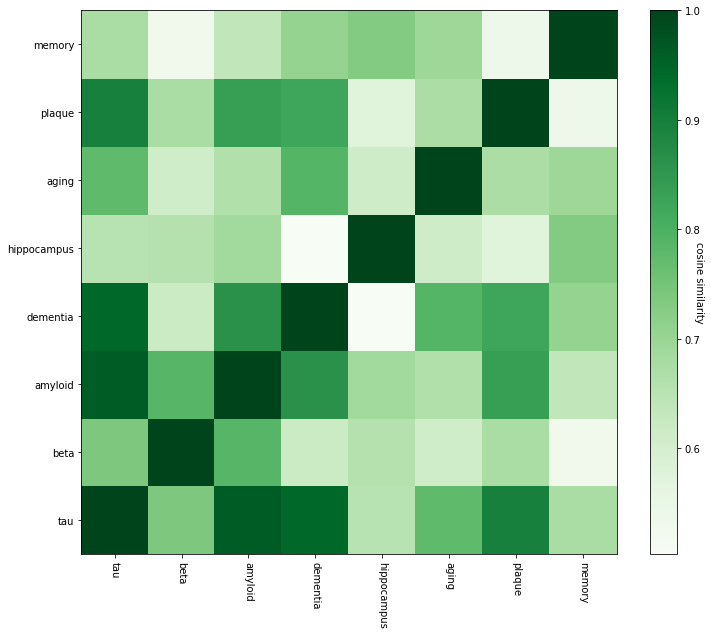

In [224]:
fig, ax = plt.subplots(figsize=(12,10))
hmap = ax.pcolor(heatmapMatrix, cmap='Greens')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

In [222]:
alzheimer_indices = []
for index, row in psyc.iterrows():
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    if len(docKeywords)>3: #If >3, very likely an alzheimer article
        alzheimer_indices.append(index)

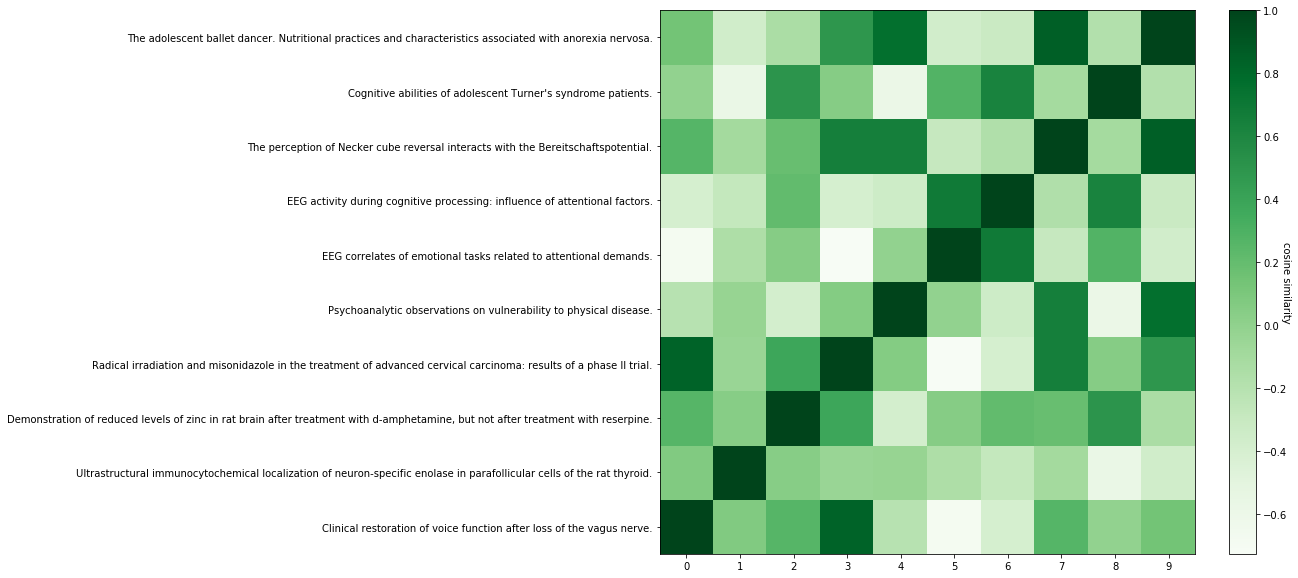

In [243]:
#Plot heatmap

targetDocs = psyc['title'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = keywordsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, keywordsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

fig, ax = plt.subplots(figsize=(12,10))
hmap = ax.pcolor(heatmapMatrixD, cmap='Greens')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(range(10), minor=False) #didn't show label because otherwise the graph would be too large
a = ax.set_yticklabels(targetDocs, minor=False)

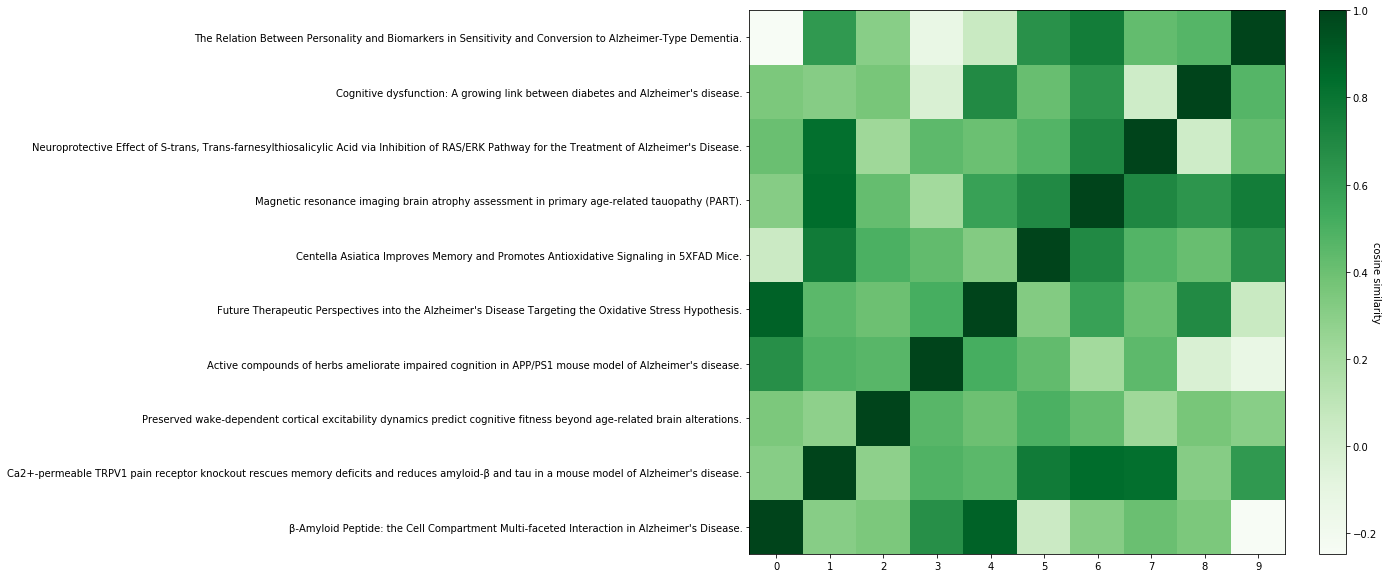

In [244]:
#Plot heatmap

targetDocs = psyc['title'][alzheimer_indices[:10]]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = keywordsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, keywordsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

fig, ax = plt.subplots(figsize=(12,10))
hmap = ax.pcolor(heatmapMatrixD, cmap='Greens')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(range(10), minor=False) #didn't show label because otherwise the graph would be too large
a = ax.set_yticklabels(targetDocs, minor=False)

    The above two heatmaps include different articles. For the first heatmap, first ten articles in the dataset were included. For the second heatmap, first ten articles that include more than 3 alzheimer-related keywords were included. We see in the second heatmap that most articles are indeed related with Alzheimer, and that on average, these articles have higher coscine similarities with each other when compared with articles in the first heatmap. This intuitively make sense because documents that talk about Alzheimer should have similar abstracts, and so they should be closer to each other in the vector space when compared with other articles.

## <span style="color:purple">*Exercise 3*</span>

<span style="color:purple">Construct cells immediately below this that embed documents related to your final project, then generate meaningful semantic dimensions based on your theoretical understanding of the semantic space (i.e., by subtracting semantically opposite word vectors) and project another set of word vectors onto those dimensions. Interpret the meaning of these projections for your analysis. Which of the dimensions you analyze explain the most variation in the projection of your words and why? 

<span style="color:purple">***Stretch***: Average together multiple antonym pairs to create robust semantic dimensions. How do word projections on these robust dimensions differ from single-pair dimensions?

    I will be using abstractW2V_2019 for this assignment.

In [284]:
#three different kinds of diseases: huntington, alzheimer, schizophrenia
tnytTargetWords = ['huntington','alzheimer','schizophrenia']
#words we will be mapping
tnytTargetWords += ["genetic", "disorder","mental","abnormal","inflammation","chronic",
                    "tau","beta","amyloid","dementia","aging", "memory", "hippocampus",
                    "seizure","impairment", "neurodegenerative", "progressive"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(abstractW2V_2019[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [285]:
#T-SNE
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

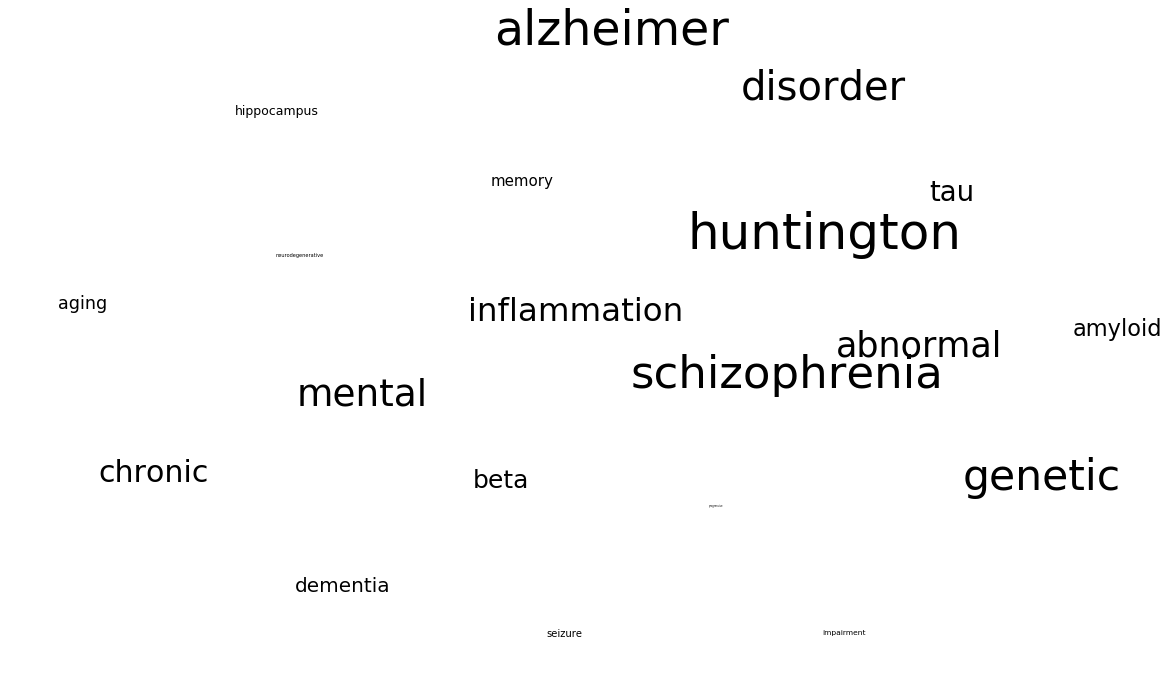

In [286]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

In [287]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [329]:
#This data doesn't have clear dimensions like gender or race (it's hard to define a dimension by a few words)
#will try to divide by  animal used in experiment
animal = dimension(abstractW2V_2019, ['monkeys'], ['rat','mice','mouse'])

#define experiment animals
subfield = ['cerebral','hippocampus','hypothalamus','prefrontal', 'offspring', 'beta', 'amyloid',
            'drugs','stimulus','stimuli','development','infant','memory','control']

In [330]:
def makeDF(model, word_list):
    s = []
    for word in word_list:
        s.append(sklearn.metrics.pairwise.cosine_similarity(abstractW2V_2019[word].reshape(1,-1), 
                                                            animal.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'animal': s}, index = word_list)
    return df

In [331]:
sub_df = makeDF(abstractW2V_2019, subfield) 

In [332]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

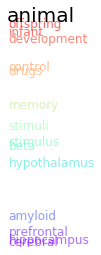

In [333]:
fig = plt.figure(figsize = (4,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, sub_df, 'animal')

    From the above graph we see that for child development-related research, researchers probably use monkeys more often than rats, whereas for brain-related research (involving hippocampus, prefrontal cortex, etc), researchers use rats and mice more often. Coming from a psycholgoy background, I think this result intuitively make sense because monkeys are indeed more often used to test development & early cognitive functions, whereas rats are used more often in memory-related tasks (involving key structures like hippocampus).
    
    We also see that 'control' and 'drugs' are two more neutral words, which probably suggest that both monkey and rat experiments include controls/involve drugs.

## <span style="color:purple">*Exercise 4b*</span>

<span style="color:purple">**Do only 4a or 4b.** Construct cells immediately below this that align word embeddings over time or across domains/corpora. Interrogate the spaces that result and ask which words changed most and least over the entire period or between contexts/corpora. What does this reveal about the social game underlying your space? 
    

    To do this exercise, 

In [335]:
psyc.head(2)

,title,abstract,affiliations,authors,chemical_list,country,pubdate,flag_psych,tokenized_abstract,normalized_abstract,TaggedAbstracts,tokenized_abstract_words,normalized_words
0,Clinical restoration of voice function after l...,One hundred eleven patients with unilateral vo...,,RS Weber;L Neumayer;BR Alford;SC Weber,D011138:Polytetrafluoroethylene,United States,1985,True,"[[One, hundred, eleven, patients, with, unilat...","[[patients, unilateral, vocal, cord, paralysis...","([patients, unilateral, vocal, cord, paralysis...","[One, hundred, eleven, patients, with, unilate...","[patients, unilateral, vocal, cord, paralysis,..."
1,Ultrastructural immunocytochemical localizatio...,"Using pre- and post-embedding procedures, neur...",,M Zabel;H Schäfer,D002116:Calcitonin; D010751:Phosphopyruvate Hy...,Germany,1985,True,"[[Using, pre-, and, post, embedding, procedure...","[[pre-, post, embedding, procedures, neuron, s...","([pre-, post, embedding, procedures, neuron, s...","[Using, pre-, and, post, embedding, procedures...","[pre-, post, embedding, procedures, neuron, sp..."


In [347]:
files = ['pubmed20n0299','pubmed20n0410','pubmed20n0631']

psyc_new = pd.DataFrame()

for file in files:
    path = './{}.xml.gz'.format(file)
    data = process_data(path)
    psyc_new = pd.concat([psyc_new,data], axis=0).reset_index(drop=True)

File ./pubmed20n0299.xml.gz done (15.354 s)
File ./pubmed20n0410.xml.gz done (15.848 s)
File ./pubmed20n0631.xml.gz done (17.500 s)


In [351]:
#normalize and tokenize （took really long to run)
psyc_new['tokenized_abstract'] = psyc_new['abstract'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
psyc_new['normalized_abstract'] = psyc_new['tokenized_abstract'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])
psyc_new['tokenized_abstract_words'] = psyc_new['abstract'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
psyc_new['normalized_words'] = psyc_new['tokenized_abstract_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [352]:
df = pd.concat([psyc, psyc_new], axis=0).reset_index(drop=True)

In [353]:
df.to_csv('psyc_pubmed_cleaned.csv')

In [354]:
print(len(df))
df.pubdate.value_counts()

17647


2019    4331
2009    3429
1985    2500
1996    2234
2002    1777
2003    1511
1997    1203
2010     224
1995     129
2008      73
2006      60
2000      50
2007      43
1998      25
1999      21
2001      19
2011       9
1994       4
1980       4
2004       1
Name: pubdate, dtype: int64

In [379]:
df = df.query("pubdate in ['2019','2009','1985','1996','2002','2003','1997']")
#keep only the years with more than 1000 articles 

In [380]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In [382]:
def compareModels(df, category, text_column_name='normalized_abstract', sort = True, embeddings_raw={}):
    """If you are using time as your category sorting is important"""
    if len(embeddings_raw) == 0:
        embeddings_raw = rawModels(df, category, text_column_name, sort)
    cats = sorted(set(df[category]))
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], 
                                                                              embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [383]:
def rawModels(df, category, text_column_name='normalized_sents', sort = True):
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF[text_column_name].sum())
    return embeddings_raw

In [384]:
rawEmbeddings, comparedEmbeddings = compareModels(df, 'pubdate')

In [385]:
rawEmbeddings.keys()

dict_keys(['1985', '1996', '1997', '2002', '2003', '2009', '2019'])

In [386]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pandas.DataFrame(dists, index = cats)

age


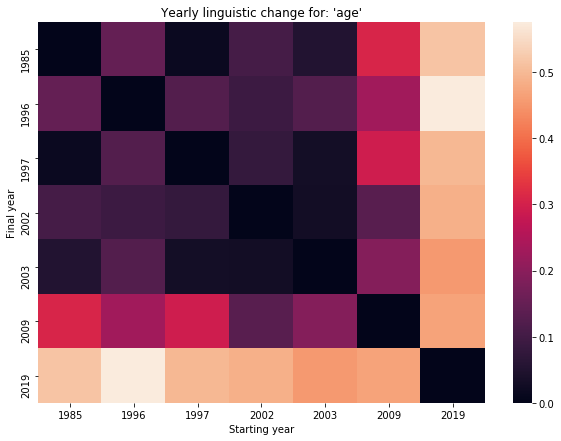

In [403]:
targetWord = 'age'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

    In the final project, I will download each year's data and so the time axis is going to be more consistent. 
    
    We see in the above graph that the usage of 'age' in 2019 is very diffferent from all the other years, usage of 'age' in 2009 is also different from the other years, but the difference is smaller when compared with 2019 corpus. Researchers seemd to have used the word 'age' from 1985-2003 similarly. 

In [393]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)
    

In [394]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 3065 words to compare


In [395]:
print('Top 10 most divergent words')
wordDivergences[:10]

Top 10 most divergent words


[('=', 2.5558676719665527),
 ('mg', 2.4011752605438232),
 ('p', 2.361671209335327),
 ('n', 2.3465930819511414),
 ('kg', 2.2261936962604523),
 ('group', 1.2777382135391235),
 ('years', 1.1580249071121216),
 ('age', 1.1484763324260712),
 ('cell', 1.1327269971370697),
 ('i.p', 1.093442142009735)]

In [396]:
print('Top 10 least divergent words')
wordDivergences[-10:]

Top 10 least divergent words


[('raised', 0.011366784572601318),
 ('identical', 0.010919928550720215),
 ('failed', 0.010779917240142822),
 ('reflex', 0.010573744773864746),
 ('evident', 0.010476231575012207),
 ('fact', 0.010460078716278076),
 ('positions', 0.00999516248703003),
 ('respond', 0.008635640144348145),
 ('moving', 0.006587564945220947),
 ('joint', 0.006571769714355469)]

=


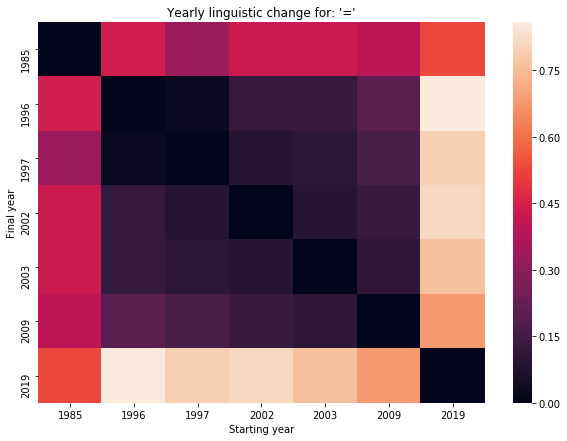

In [397]:
targetWord = wordDivergences[0][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

joint


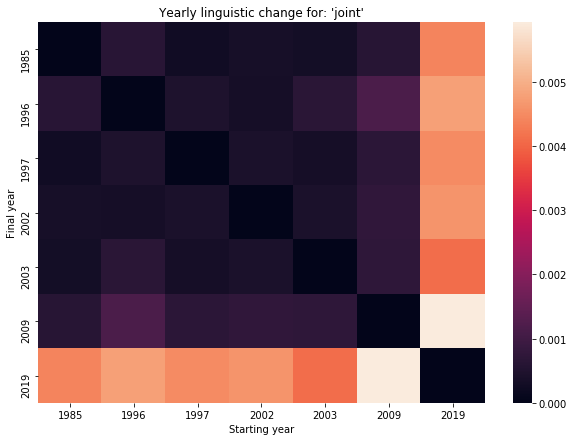

In [398]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

    The most divergent word is actually a sign, "=", where as the least divergent word is 'joint'. Examining the list further, we see that researchers are using words such as 'identical', 'positions', very similarly across years, and that researchers are using words such as 'group', 'cell' very differently.